# Image Classification using SVM

In [65]:
#To avoid keras,tf compatibility warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
from pathlib import Path

In [4]:
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
p = Path("./Dataset/")
for i in (p.glob("*")):
      print(i)

Dataset/horses
Dataset/humans
Dataset/dogs
Dataset/cats


In [6]:
labels_dict = {}

target_labels = []
image_data = []

for i,folder in enumerate(p.glob("*")):
    label = str(folder).split("/")[-1][:-1]
    labels_dict[label] = i
    
    for image_path in folder.glob("*"):
        img = image.load_img(image_path,target_size=(100,100))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        target_labels.append(i)
    

In [7]:
N_CLASSES = len(labels_dict)

In [8]:
image_data = np.array(image_data,dtype='float32')/255.0
target_labels = np.array(target_labels)

In [9]:
print(image_data.shape,target_labels.shape)

(808, 100, 100, 3) (808,)


### Shuffle data

In [10]:
import random

In [11]:
def randomize_data(image_data,labels):
    zipped = list(zip(image_data,labels))
    random.shuffle(zipped)
    image_data[:],labels[:] = zip(*zipped)

In [13]:
randomize_data(image_data,target_labels)

### View Images

In [16]:
def showImg(img):
    plt.imshow(img.reshape(100,100,3))
    plt.axis("off")

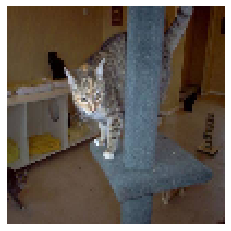

In [17]:
showImg(image_data[0])

## SVM classifier

In [18]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hinge_loss(self,W,b,X,Y):
        C = self.C
        loss = 0.5*np.dot(W,W.T)
        loss = loss[0][0]
        
        t = Y*(np.dot(W,X.T)+b)
        t = 1-t
        t[t<0]=0
        error = C*t.sum()
        
        loss+= error

        return loss
    
    def fit(self,X,Y,learning_rate=0.001,batch_size=100,max_Iter=1000):
        
        #Init
        m,nf = X.shape[0],X.shape[1]
        C = self.C
        W = np.zeros((1,nf))
        b = 0
        losses = []        
        
        for Iter in range(max_Iter):
            losses.append(self.hinge_loss(W,b,X,Y))
            
            ind = np.arange(m)
            np.random.shuffle(ind)
            #mini-batch
            for batch_start in range(0,m,batch_size):

                gradW,gradb=np.zeros((1,nf),dtype='float'),0
                #Gradient for batch
                for j in range(batch_start,batch_start+batch_size):
                    if j==m:
                        break
                    i = ind[j]
                    t = Y[i]*(np.dot(W,X[i].T)+b)
                    
                    if t<=1:
                        gradW += -1*Y[i]*X[i]
                        gradb += -Y[i]
                    else:
                        pass
                         # 0 contributions
                gradW*=C
                gradW = np.reshape(gradW,(1,-1))
                gradW+=W

                W -= learning_rate*gradW
                b -= learning_rate*gradb
                
                
        self.W = W
        self.b = b
        return W,b,losses

## Data helper functions


In [19]:
m = image_data.shape[0]
image_data = image_data.reshape(m,-1)

print(image_data.shape)
print(target_labels.shape)

(808, 30000)
(808,)


In [20]:
def classWiseData(X,Y):
    data = {}
    for i in range(N_CLASSES):
        data[i] = []
    
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
        
    for i in range(N_CLASSES):
        data[i] = np.array(data[i])
    
    return data

In [21]:
def pairwiseData(d1,d2):
    m1,m2 = d1.shape[0],d2.shape[0]
    data = np.vstack((d1,d2))
    
    labels = np.zeros((m1+m2,))
    labels[:m1] = -1
    labels[m2:] = 1
    
    return data,labels    

# Train all 1vs1 classifiers

In [22]:
data = classWiseData(image_data,target_labels)

In [45]:
def train(X):
    svc = SVM()
    svm_classifiers = {}
    
    for i in range(N_CLASSES):
        svm_classifiers[i] = {}
        
        for j in range(i+1,N_CLASSES):
            print(i,j)
            x,y = pairwiseData(data[i],data[j])
            print("Train start",end=" ")
            W,b,losses = svc.fit(x,y,
                                 learning_rate=0.000001,
                                 max_Iter=2000)
            print("Train end")
            svm_classifiers[i][j] = (W,b)
            plt.plot(losses)
            plt.show()
    return svm_classifiers

0 1
Train start Train end


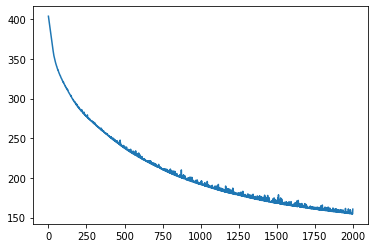

0 2
Train start Train end


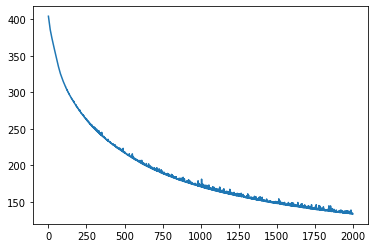

0 3
Train start Train end


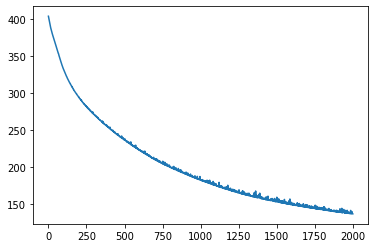

1 2
Train start Train end


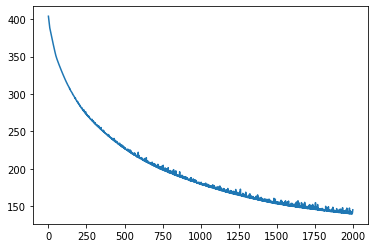

1 3
Train start Train end


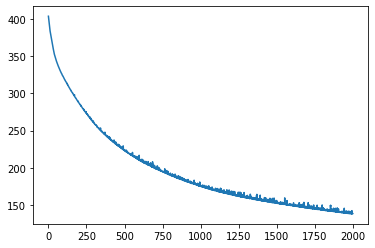

2 3
Train start Train end


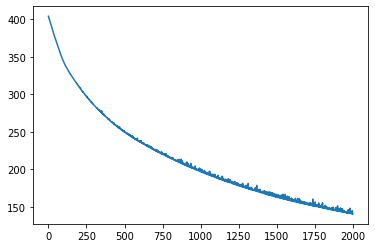

In [46]:
svm_classifiers = train(data)

In [47]:
def binaryPredict(x,W,b):
    z = np.dot(x,W.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [48]:
def predict(x):
    count = np.zeros((N_CLASSES,))
    
    for i in range(N_CLASSES):
        for j in range(i+1,N_CLASSES):
            W,b = svm_classifiers[i][j]
            
            if binaryPredict(x,W,b)==-1:
                count[i]+=1
            else:
                count[j]+=1
    return np.argmax(count)

In [49]:
count = 0
m = image_data.shape[0]
for i in range(m):
    if predict(image_data[i])==target_labels[i]:
        count+=1

accuracy = count/m*100
accuracy

64.10891089108911

In [54]:
#Early stopping

# SVM with sklearn

In [50]:
from sklearn import svm

In [61]:
svm_sklearn = svm.SVC(kernel='linear',C=1.0)

In [63]:
svm_sklearn.fit(image_data,target_labels)
svm_sklearn.score(image_data,target_labels)

0.6658415841584159